In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pyinterp

## Open datasets

In [2]:
dir_data = "/workspace/project/ssh_mapping/data/"

#### 1D observations 

In [3]:
path_obs = [
    f"{dir_data}/dc_obs/2020a_SSH_mapping_NATL60_envisat.nc",
    f"{dir_data}/dc_obs/2020a_SSH_mapping_NATL60_geosat2.nc",
    f"{dir_data}/dc_obs/2020a_SSH_mapping_NATL60_jason1.nc",
    f"{dir_data}/dc_obs/2020a_SSH_mapping_NATL60_topex-poseidon_interleaved.nc",
]

ds_obs = [xr.open_dataset(path) for path in path_obs]

#### 2D reference fields

In [4]:
ds_ref = xr.open_mfdataset(f"{dir_data}/dc_ref/*.nc")
ds_ref = ds_ref.assign_coords({ 'lon':('lon', ds_ref.lon.data % 360) }) # convert longitudes to [0,360]
ds_ref

<xarray.Dataset>
Dimensions:   (time: 8760, lat: 600, lon: 600)
Coordinates:
  * lon       (lon) float64 295.0 295.0 295.0 295.1 ... 304.9 305.0 305.0 305.0
  * lat       (lat) float64 33.02 33.03 33.05 33.07 ... 42.95 42.97 42.98 43.0
  * time      (time) datetime64[ns] 2012-10-01T00:30:00 ... 2013-09-30T23:30:00
Data variables:
    sossheig  (time, lat, lon) float32 dask.array<chunksize=(24, 600, 600), meta=np.ndarray>
Attributes:
    Info:     Horizontal grid read in regulargrid_NATL60.nc / Source field re...
    About:    Created by SOSIE interpolation environement => https://github.c...

## Create regular grid

In [9]:
# Create a regular grid for lon and lat
lon_min, lon_max = ds_ref.lon.min().values,ds_ref.lon.max().values
lat_min, lat_max = ds_ref.lat.min().values,ds_ref.lat.max().values
time_min, time_max = ds_ref.time.min().values,ds_ref.time.max().values
dlon = dlat = 0.1 # °
dt = 1 # days
lon_regular = np.arange(lon_min, lon_max, dlon)
lat_regular = np.arange(lat_min, lat_max, dlat)
# lon_regular = np.linspace(lon_min, lon_max, 572)
# lat_regular = np.linspace(lat_min, lat_max, 572)
lon_grid, lat_grid = np.meshgrid(lon_regular, lat_regular)
time_regular = np.arange(time_min, time_max, np.timedelta64(dt, 'D'))

## Projections

#### Binning observations

In [12]:
# Prepare a container for the new grid data
ssh_grid = np.empty((len(time_regular), lat_regular.size, lon_regular.size))

# Initialize binning object
binning = pyinterp.Binning2D(
    pyinterp.Axis(lon_regular, is_circle=True),
    pyinterp.Axis(lat_regular),
    )

# Interpolate data for each time step
for t_idx, time in enumerate(time_regular):

    binning.clear()

    # Loop on datasets
    lon1d = np.array([])
    lat1d = np.array([])
    ssh1d = np.array([])
    for _ds_obs in ds_obs:
        # Mask for the current time step within a tolerance
        mask = np.abs(_ds_obs.time - time) <= np.timedelta64(int(5*24*dt/2), 'h')
        _ds_obs_mask = _ds_obs.where(mask, drop=True)
        ssh1d = np.concatenate((ssh1d,_ds_obs_mask.ssh_model.values))
        lon1d = np.concatenate((lon1d,_ds_obs_mask.lon.values))
        lat1d = np.concatenate((lat1d,_ds_obs_mask.lat.values))

    # Binning data
    binning.push(lon1d,lat1d,ssh1d, True)

    ssh_grid[t_idx, :, :] = binning.variable('mean').T


# Create a new xarray dataset
ds_inputs = xr.Dataset(
    {
        "ssh": (["time", "lat", "lon"], ssh_grid)
    },
    coords={
        "time": time_regular,
        "lat": lat_regular,
        "lon": lon_regular
    }
)

# Save the new dataset
ds_inputs.to_netcdf("data_inputs_5days.nc")

print(ds_inputs)

ds_inputs.close()


<xarray.Dataset>
Dimensions:  (time: 365, lat: 100, lon: 100)
Coordinates:
  * time     (time) datetime64[ns] 2012-10-01T00:30:00 ... 2013-09-30T00:30:00
  * lat      (lat) float64 33.02 33.12 33.22 33.32 ... 42.62 42.72 42.82 42.92
  * lon      (lon) float64 295.0 295.1 295.2 295.3 ... 304.6 304.7 304.8 304.9
Data variables:
    ssh      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan


In [11]:
ds_inputs

<xarray.Dataset>
Dimensions:  (time: 365, lat: 100, lon: 100)
Coordinates:
  * time     (time) datetime64[ns] 2012-10-01T00:30:00 ... 2013-09-30T00:30:00
  * lat      (lat) float64 33.02 33.12 33.22 33.32 ... 42.62 42.72 42.82 42.92
  * lon      (lon) float64 295.0 295.1 295.2 295.3 ... 304.6 304.7 304.8 304.9
Data variables:
    ssh      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

#### Regridding reference fields

In [8]:
# Define source grid
x_source_axis = pyinterp.Axis(ds_ref.lon.values, is_circle=True)
y_source_axis = pyinterp.Axis(ds_ref.lat.values)
z_source_axis = pyinterp.TemporalAxis(ds_ref.time.values)
grid_source = pyinterp.Grid3D(x_source_axis, y_source_axis, z_source_axis, ds_ref.sossheig.T)

# Define target grid
time_target = z_source_axis.safe_cast(np.ascontiguousarray(time_regular))
z_target = np.tile(time_target,(lon_regular.size,lat_regular.size,1))
nt = len(time_regular)
x_target = np.repeat(lon_grid.transpose()[:,:,np.newaxis],nt,axis=2)
y_target = np.repeat(lat_grid.transpose()[:,:,np.newaxis],nt,axis=2)

# Interpolation
ssh_interp = pyinterp.trivariate(grid_source,
                                x_target.flatten(),
                                y_target.flatten(),
                                z_target.flatten(),
                                bounds_error=False).reshape(x_target.shape).T

# Create a new xarray dataset
ds_target = xr.Dataset(
    {
        "ssh": (["time", "lat", "lon"], ssh_interp)
    },
    coords={
        "time": time_regular,
        "lat": lat_regular,
        "lon": lon_regular
    }
)

# Save the new dataset
ds_target.to_netcdf("data_target.nc")

print(ds_target)

ds_target.close()

<xarray.Dataset>
Dimensions:  (time: 365, lat: 100, lon: 100)
Coordinates:
  * time     (time) datetime64[ns] 2012-10-01T00:30:00 ... 2013-09-30T00:30:00
  * lat      (lat) float64 33.02 33.12 33.22 33.32 ... 42.62 42.72 42.82 42.92
  * lon      (lon) float64 295.0 295.1 295.2 295.3 ... 304.6 304.7 304.8 304.9
Data variables:
    ssh      (time, lat, lon) float64 0.5111 0.5266 0.5418 ... -0.1684 -0.1416


## Plot

In [12]:
ds_inputs = xr.open_dataset("data_inputs_HR_5days.nc")
ds_target = xr.open_dataset("data_target_HR.nc")

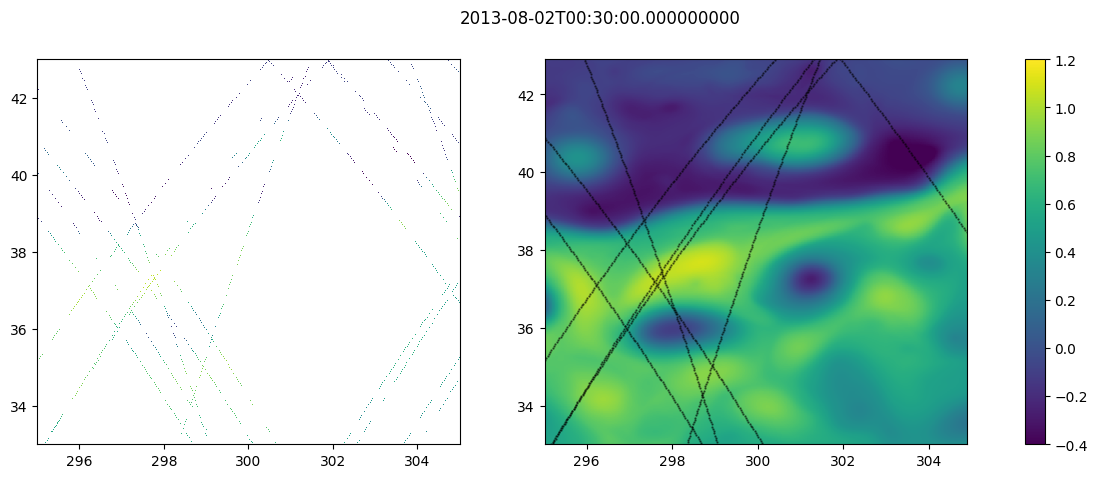

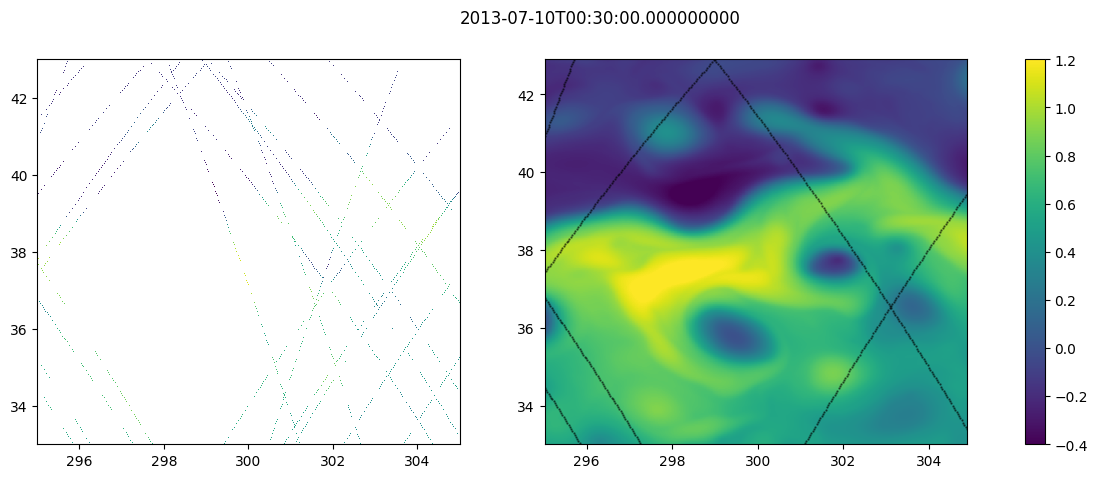

In [13]:
for _ in range(2):

    t = np.random.randint(0,365)

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
    fig.suptitle(ds_inputs.time[t].values)

    im = ax1.pcolormesh(lon_regular, lat_regular, ds_inputs.ssh[t], vmin=-.4, vmax=1.2)
    ax2.pcolormesh(lon_regular, lat_regular, ds_target.ssh[t], vmin=-.4, vmax=1.2)
    for ds in ds_obs:
        _ds = ds.sel(time=slice(ds_inputs.time[t]-np.timedelta64(int(24*dt/2), 'h'), ds_inputs.time[t]+np.timedelta64(int(24*dt/2), 'h')))
        ax2.scatter(_ds.lon, _ds.lat, c='k', alpha=.5, s=0.5)
        ax2.set_xlim([lon_min,lon_max-.1])
        ax2.set_ylim([lat_min,lat_max-.1])

    plt.colorbar(im, ax=(ax1,ax2))
    plt.show()

## Data Exploration

In [77]:
print(ds_inputs["ssh"].shape)
print(ds_target["ssh"].shape)

(365, 100, 100)
(365, 100, 100)


In [83]:
print(f'Start date of ds_inputs: {ds_inputs["ssh"].time[0].values}')
print(f'Start date of ds_inputs: {ds_inputs["ssh"].time[-1].values}')

Start date of ds_inputs: 2012-10-01T00:30:00.000000000
Start date of ds_inputs: 2013-09-30T00:30:00.000000000


In [79]:
total_nan = ds_inputs["ssh"].isnull().sum()
ratio = total_nan.values * 100 / ds_inputs["ssh"].size
print(f'Total number of NaN in ds_inputs: {total_nan.values}')
print(f'Total number data in ds_inputs: {ds_inputs["ssh"].size}')
print(f'Ratio of NaN values: {ratio}')

Total number of NaN in ds_inputs: 3515147
Total number data in ds_inputs: 3650000
Ratio of NaN values: 96.30539726027398


31
2012-11-01T00:30:00.000000000


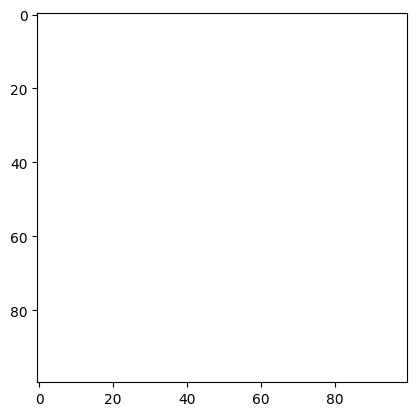

In [81]:
nan_values = []
array_size = ds_inputs["ssh"].shape[1] * ds_inputs["ssh"].shape[2]
for index in range(ds_inputs["ssh"].shape[0]):

    if ds_inputs["ssh"][index].isnull().sum().values == array_size:
        nan_values.append(index)
        print(index)
        print(ds_inputs["ssh"].time[index].values)
        plt.imshow(ds_inputs["ssh"][index])

    else:
        nan_values.append(0)

Maybe need to remove this data later use the one from h -1 or h + 1

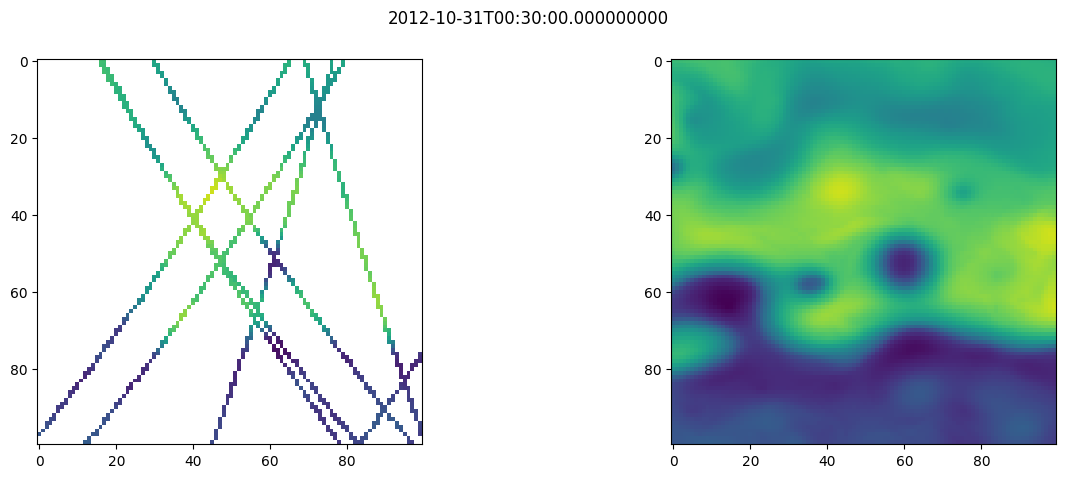

In [86]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle(ds_inputs.time[30].values)
ax1.imshow(ds_inputs.ssh[30], vmin=-.4, vmax=1.2)
ax2.imshow(ds_target.ssh[30], vmin=-.4, vmax=1.2)
plt.show()

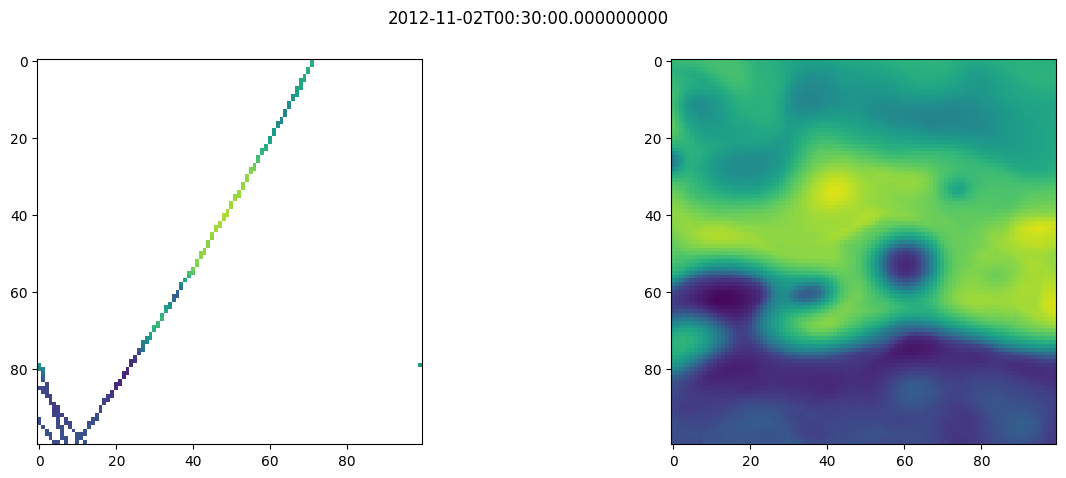

In [88]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle(ds_inputs.time[32].values)
ax1.imshow(ds_inputs.ssh[32].values, vmin=-.4, vmax=1.2)
ax2.imshow(ds_target.ssh[32].values, vmin=-.4, vmax=1.2)
plt.show()

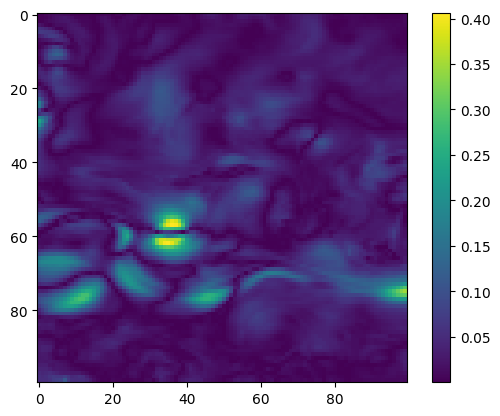

In [95]:
plt.imshow(np.abs(ds_target.ssh[32].values-ds_target.ssh[30].values))
plt.colorbar()
plt.show()